In [1]:
# Generate data for long only portfolio optimization.
import numpy as np
np.random.seed(1)
n = 20
mu = np.abs(np.random.randn(n, 1))
Sigma = np.random.randn(n, n)
Sigma = Sigma.T.dot(Sigma)

In [2]:
# Long only portfolio optimization.
import cvxpy as cp


w = cp.Variable(n)
gamma = cp.Parameter(nonneg=True)
ret = mu.T*w 
risk = cp.quad_form(w, Sigma)
prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1, 
                w >= 0])

In [3]:
# Compute trade-off curve.
SAMPLES = 100
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    risk_data[i] = cp.sqrt(risk).value
    ret_data[i] = ret.value

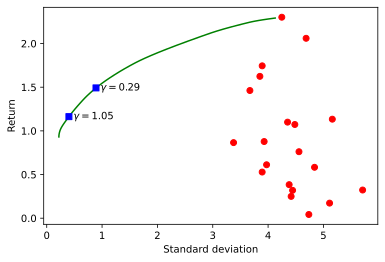

In [4]:
# Plot long only trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [29, 40]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+.08, ret_data[marker]-.03))
for i in range(n):
    plt.plot(cp.sqrt(Sigma[i,i]).value, mu[i], 'ro')
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

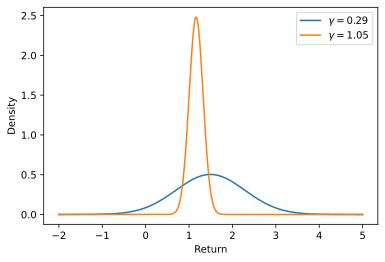

In [5]:
# Plot return distributions for two points on the trade-off curve.
import scipy.stats as spstats


plt.figure()
for midx, idx in enumerate(markers_on):
    gamma.value = gamma_vals[idx]
    prob.solve()
    x = np.linspace(-2, 5, 1000)
    plt.plot(x, spstats.norm.pdf(x, ret.value, risk.value), label=r"$\gamma = %.2f$" % gamma.value)

plt.xlabel('Return')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

In [6]:
# Portfolio optimization with leverage limit.
Lmax = cp.Parameter()
prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1, 
                cp.norm(w, 1) <= Lmax])

In [7]:
# Compute trade-off curve for each leverage limit.
L_vals = [1, 2, 4]
SAMPLES = 100
risk_data = np.zeros((len(L_vals), SAMPLES))
ret_data = np.zeros((len(L_vals), SAMPLES))
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
w_vals = []
for k, L_val in enumerate(L_vals):
    for i in range(SAMPLES):
        Lmax.value = L_val
        gamma.value = gamma_vals[i]
        prob.solve(solver=cp.SCS)
        risk_data[k, i] = cp.sqrt(risk).value
        ret_data[k, i] = ret.value

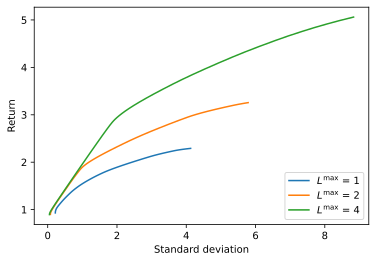

In [8]:
# Plot trade-off curves for each leverage limit.
for idx, L_val in enumerate(L_vals):
    plt.plot(risk_data[idx,:], ret_data[idx,:], label=r"$L^{\max}$ = %d" % L_val)
for w_val in w_vals:
    w.value = w_val
    plt.plot(cp.sqrt(risk).value, ret.value, 'bs')
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.legend(loc='lower right')
plt.show()

In [9]:
prob = cp.Problem(cp.Maximize(ret), 
              [cp.sum(w) == 1, 
               cp.norm(w, 1) <= Lmax,
               risk <= 2])

In [10]:
# Compute solution for different leverage limits.
for k, L_val in enumerate(L_vals):
    Lmax.value = L_val
    prob.solve()
    w_vals.append( w.value )

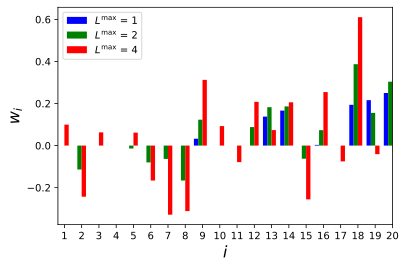

In [11]:
# Plot bar graph of holdings for different leverage limits.
colors = ['b', 'g', 'r']
indices = np.argsort(mu.flatten())
for idx, L_val in enumerate(L_vals):
     plt.bar(np.arange(1,n+1) + 0.25*idx - 0.375, w_vals[idx][indices], color=colors[idx], 
             label=r"$L^{\max}$ = %d" % L_val, width = 0.25)
plt.ylabel(r"$w_i$", fontsize=16)
plt.xlabel(r"$i$", fontsize=16)
plt.xlim([1-0.375, 10+.375])
plt.xticks(np.arange(1,n+1))
plt.legend(loc = 'upper left')
plt.show()

In [12]:
# Generate data for factor model.
n = 3000
m = 50
np.random.seed(1)
mu = np.abs(np.random.randn(n, 1))
Sigma_tilde = np.random.randn(m, m)
Sigma_tilde = Sigma_tilde.T.dot(Sigma_tilde)
D = np.diag(np.random.uniform(0, 0.9, size=n))
F = np.random.randn(n, m)

In [13]:
# Factor model portfolio optimization.
w = cp.Variable(n)
f = F.T*w
gamma = cp.Parameter(nonneg=True)
Lmax = cp.Parameter()
ret = mu.T*w 
risk = cp.quad_form(f, Sigma_tilde) + cp.quad_form(w, D)
prob_factor = cp.Problem(cp.Maximize(ret - gamma*risk), 
                     [cp.sum(w) == 1, 
                      cp.norm(w, 1) <= Lmax])

# Solve the factor model problem.
Lmax.value = 2
gamma.value = 0.1
prob_factor.solve(verbose=True)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 6050, constraints m = 6052
          nnz(P) + nnz(A) = 172325
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -2.1359e+03   7.63e+00   3.73e+02   1.00e-01   6.49e-02s
 200  -4.1946e+00   1.59e-03   7.86e-03   3.60e-01   3.97e-01s
 400  -4.6288e+00   3.02e-04   6.01e-04 

4.606413081938858

In [14]:
# Standard portfolio optimization with data from factor model.
risk = cp.quad_form(w, F.dot(Sigma_tilde).dot(F.T) + D)
prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1, 
                cp.norm(w, 1) <= Lmax])


# Uncomment to solve the problem.
# WARNING: this will take many minutes to run.
prob.solve(verbose=True,solver=cp.OSQP,
           eps_abs=1e-02)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 6000, constraints m = 6002
          nnz(P) + nnz(A) = 4519500
settings: linear system solver = qdldl,
          eps_abs = 1.0e-02, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.1774e+04   2.65e+02   1.51e+04   1.00e-01   8.30e+00s
 200  -4.1080e+02   2.42e-01   8.86e-04   1.00e-01   1.13e+01s
 400  -1.9413e+02   1.13e-01   2.51e-04

19.68024974042952

In [15]:
print('Factor model solve time = {}'.format(prob_factor.solver_stats.solve_time))
print('Single model solve time = {}'.format(prob.solver_stats.solve_time))

Factor model solve time = 2.4472487450000004
Single model solve time = 48.913372546000005


(array([ 1.,  2.,  2.,  3.,  6.,  6.,  6., 10., 12.,  5., 10., 11.,  7.,
        10.,  4.,  2.,  1.,  0.,  1.,  1.]),
 array([-2.47191684, -2.21056802, -1.94921921, -1.68787039, -1.42652157,
        -1.16517275, -0.90382393, -0.64247511, -0.38112629, -0.11977747,
         0.14157134,  0.40292016,  0.66426898,  0.9256178 ,  1.18696662,
         1.44831544,  1.70966426,  1.97101307,  2.23236189,  2.49371071,
         2.75505953]),
 <a list of 20 Patch objects>)

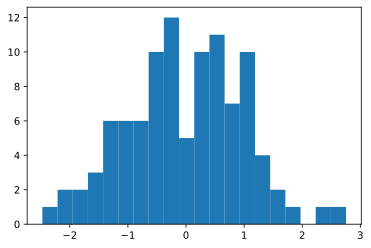

In [18]:
plt.hist(np.random.normal(size=100),bins=20)